In [209]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import tensorflow as tf
import larq as lq

from utils import prepare_dataset, generate_data_loaders, run_experiment
from models import generate_quantized_gcn, generate_standard_gcn

from tqdm import trange

import pandas as pd

# Setup

In [3]:
import warnings
warnings.filterwarnings('ignore')

cora_dataset = prepare_dataset("Cora")
pubmed_dataset = prepare_dataset("PubMed")

warnings.filterwarnings("once")

Pre-processing node features
Dataset:  cora
Size of train set: 140
Size of val set: 500
Size of test set: 1000
Num classes: 7
Num features: 1433
Pre-processing node features
Dataset:  pubmed
Size of train set: 60
Size of val set: 500
Size of test set: 1000
Num classes: 3
Num features: 500


# Experiment 1: GCN baseline (no quantization)

Following the architecture and hyperparameters settings of Kipf & Welling (2016)

## Cora

In [5]:
input_shapes = (cora_dataset.graphs[0].x.shape[1], cora_dataset.graphs[0].a.shape[1])
model_factory = lambda : generate_standard_gcn(channels=64, input_shapes=input_shapes, dataset=cora_dataset, dropout_rate=0.5, layers=2)[0]
model_factory().summary()

Instructions for updating:
Use `tf.linalg.matmul` instead
Model: "BiGCN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1433)         0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           91776       ['dropout[0][0]']                
                                                                                                  
 graph_conv (GraphConv)         (2708, 64)           0           ['dense[0][0]']                  
                                    

In [5]:
num_runs = 20
epochs = 1000
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# Note: need to explicitly specify reduction = "sum" to correctly scale loss, otherwise it will be divided by the batch size
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

run_experiment(
    experiment_name="standard_gcn_baseline", 
    num_runs=num_runs, 
    epochs=epochs, 
    optimizer=optimizer,
    dataset=cora_dataset,
    model_factory=model_factory,
    loss_function=loss_function,
    callbacks=[early_stopping_callback]
    )

100%|██████████| 20/20 [01:33<00:00,  4.67s/it]

20 runs completed: 1.0000 mean train acc, 0.8037 mean val acc, 0.8175 mean test acc


# Experiment 2: Quantized GCN Baseline (Same as paper)

## Cora

In [7]:
dataset = cora_dataset
input_shapes = (dataset.graphs[0].x.shape[1], dataset.graphs[0].a.shape[1])
model_factory = lambda : generate_quantized_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    layers=2,
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_regularizer=None,
    batch_norm_scale=False,
    batch_norm_center=False)[0]

In [82]:
warnings.filterwarnings('ignore')

num_runs = 20
epochs = 1000
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")

run_experiment(
    experiment_name="binary_gcn_baseline", 
    num_runs=num_runs, 
    epochs=epochs, 
    optimizer=optimizer,
    dataset=dataset,
    model_factory=model_factory,
    loss_function=loss_function,
    callbacks=[],
    verbose=0
    )

  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:38<12:20, 38.99s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:15<11:15, 37.51s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [01:51<10:28, 36.95s/it]Using a binary

20 runs completed: 0.9600 mean train acc, 0.7718 mean val acc, 0.7837 mean test acc


# Experiment 3: Dropout - reducing the dropout rate, removing dropout, and putting dropout before vs. after the binarization

In [83]:
dataset = cora_dataset
input_shapes = (dataset.graphs[0].x.shape[1], dataset.graphs[0].a.shape[1])
num_runs = 20
epochs = 1000

for dropout_rate in [0.5, 0.4, 0.3, 0.2, 0.1, 0.0]:
    print("Dropout rate = ", dropout_rate)
    model_factory = lambda : generate_quantized_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=dropout_rate, 
    layers=2,
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_regularizer=None,
    batch_norm_scale=False,
    batch_norm_center=False)[0]

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8)
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")

    run_experiment(
        experiment_name=f"binary_gcn_dropout={dropout_rate}", 
        num_runs=num_runs, 
        epochs=epochs, 
        optimizer=optimizer,
        dataset=dataset,
        model_factory=model_factory,
        loss_function=loss_function,
        callbacks=[],
        verbose=0
        )
    

Dropout rate =  0.5


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:36<11:40, 36.88s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:13<10:57, 36.52s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [01:50<10:23, 36.69s/it]Using a binary

20 runs completed: 0.9186 mean train acc, 0.7729 mean val acc, 0.7859 mean test acc
Dropout rate =  0.4


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:38<12:07, 38.29s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:15<11:17, 37.62s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [01:53<10:42, 37.82s/it]Using a binary

20 runs completed: 0.9600 mean train acc, 0.7702 mean val acc, 0.7842 mean test acc
Dropout rate =  0.3


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:39<12:21, 39.01s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:16<11:21, 37.88s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [01:53<10:39, 37.60s/it]Using a binary

20 runs completed: 0.9875 mean train acc, 0.7664 mean val acc, 0.7819 mean test acc
Dropout rate =  0.2


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:43<13:41, 43.23s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:24<12:40, 42.26s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:08<12:08, 42.87s/it]Using a binary

20 runs completed: 0.9996 mean train acc, 0.7630 mean val acc, 0.7793 mean test acc
Dropout rate =  0.1


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:41<13:11, 41.67s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:21<12:14, 40.78s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:02<11:29, 40.54s/it]Using a binary

20 runs completed: 1.0000 mean train acc, 0.7564 mean val acc, 0.7707 mean test acc
Dropout rate =  0.0


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:39<12:31, 39.57s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:17<11:39, 38.84s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [01:55<10:51, 38.33s/it]Using a binary

20 runs completed: 1.0000 mean train acc, 0.7512 mean val acc, 0.7642 mean test acc


# Experiment 4: Allow batchnorm to be trained

In [87]:
dataset = cora_dataset
input_shapes = (dataset.graphs[0].x.shape[1], dataset.graphs[0].a.shape[1])


for batch_norm_momentum in [0.5, 0.75, 0.9, 0.95, 0.99]:
    model_factory = lambda : generate_quantized_gcn(
        channels=64, 
        input_shapes=input_shapes, 
        dataset=dataset, 
        dropout_rate=0.3, 
        layers=2,
        input_quantizer=lq.quantizers.MagnitudeAwareSign,
        kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
        kernel_regularizer=None,
        batch_norm_momentum=batch_norm_momentum,
        batch_norm_scale=True,
        batch_norm_center=True)[0]


    num_runs = 20
    epochs = 1000
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8)
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")

    run_experiment(
        experiment_name=f"binary_gcn_batchnorm_momentum={batch_norm_momentum}", 
        num_runs=num_runs, 
        epochs=epochs, 
        optimizer=optimizer,
        dataset=dataset,
        model_factory=model_factory,
        loss_function=loss_function,
        callbacks=[],
        verbose=0
        )

  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:40<12:51, 40.60s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:20<12:05, 40.32s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:00<11:18, 39.89s/it]Using a binary

KeyboardInterrupt: 

# Experiment 5: Batchnorm before every layer

In [88]:
# With magnitude aware sign
dataset = cora_dataset
input_shapes = (dataset.graphs[0].x.shape[1], dataset.graphs[0].a.shape[1])
for bn_momentum in [0.5, 0.75, 0.9, 0.95, 0.99]:

    model_factory = lambda : generate_quantized_gcn(
        channels=64, 
        input_shapes=input_shapes, 
        dataset=dataset, 
        dropout_rate=0.3, 
        layers=2,
        input_quantizer=lq.quantizers.MagnitudeAwareSign,
        kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
        kernel_regularizer=None,
        batch_norm_momentum=bn_momentum,
        batch_norm_scale=True,
        batch_norm_center=True,
        single_batch_norm=False)[0]


    num_runs = 20
    epochs = 1000
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-8)
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")

    run_experiment(
        experiment_name=f"binary_gcn_multiple_batchnorm_momentum={bn_momentum}", 
        num_runs=num_runs, 
        epochs=epochs, 
        optimizer=optimizer,
        dataset=dataset,
        model_factory=model_factory,
        loss_function=loss_function,
        callbacks=[],
        verbose=0
        )

  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:43<13:45, 43.45s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:25<12:46, 42.61s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:07<11:57, 42.21s/it]Using a binary

20 runs completed: 0.9982 mean train acc, 0.7834 mean val acc, 0.7900 mean test acc


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:44<14:13, 44.90s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:27<13:01, 43.40s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:08<12:03, 42.57s/it]Using a binary

20 runs completed: 0.9975 mean train acc, 0.7838 mean val acc, 0.7899 mean test acc


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:42<13:32, 42.78s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:25<12:46, 42.61s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:07<11:57, 42.21s/it]Using a binary

20 runs completed: 0.9968 mean train acc, 0.7818 mean val acc, 0.7925 mean test acc


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:42<13:28, 42.58s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:25<12:49, 42.77s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:08<12:05, 42.70s/it]Using a binary

20 runs completed: 0.9986 mean train acc, 0.7830 mean val acc, 0.7920 mean test acc


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:42<13:36, 42.98s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:25<12:44, 42.49s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:07<12:04, 42.64s/it]Using a binary

20 runs completed: 0.9986 mean train acc, 0.7777 mean val acc, 0.7884 mean test acc


In [63]:
# with ste sign
dataset = cora_dataset
input_shapes = (dataset.graphs[0].x.shape[1], dataset.graphs[0].a.shape[1])
for bn_momentum in [0.5]:

    model_factory = lambda : generate_quantized_gcn(
        channels=64, 
        input_shapes=input_shapes, 
        dataset=dataset, 
        dropout_rate=0.3, 
        layers=2,
        input_quantizer=lq.quantizers.MagnitudeAwareSign,
        kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
        kernel_regularizer=None,
        batch_norm_momentum=bn_momentum,
        batch_norm_scale=True,
        batch_norm_center=True,
        single_batch_norm=False)[0]


    num_runs = 1
    epochs = 1000
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-8)
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)

    model = model_factory()
    loader_tr, loader_va, loader_te = generate_data_loaders(dataset)
    model.compile(
        optimizer=optimizer, loss=loss_function, weighted_metrics=["accuracy"]
    )

    history = model.fit(
        loader_tr.load(),
        steps_per_epoch=loader_tr.steps_per_epoch,
        validation_data=loader_va.load(),
        validation_steps=loader_va.steps_per_epoch,
        epochs=epochs,
        callbacks=[],
        verbose=1,
    )

Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).


Epoch 1/1000
1/1 [==============================] - 1s 694ms/step - loss: 1.9693 - accuracy: 0.2143 - val_loss: 1.9324 - val_accuracy: 0.3180
Epoch 2/1000
1/1 [==============================] - 0s 53ms/step - loss: 1.9713 - accuracy: 0.2000 - val_loss: 1.9211 - val_accuracy: 0.2640
Epoch 3/1000
1/1 [==============================] - 0s 49ms/step - loss: 2.0364 - accuracy: 0.1571 - val_loss: 1.9086 - val_accuracy: 0.2300
Epoch 4/1000
1/1 [==============================] - 0s 47ms/step - loss: 2.0061 - accuracy: 0.1429 - val_loss: 1.8970 - val_accuracy: 0.2700
Epoch 5/1000
1/1 [==============================] - 0s 51ms/step - loss: 1.9949 - accuracy: 0.2143 - val_loss: 1.8852 - val_accuracy: 0.2520
Epoch 6/1000
1/1 [==============================] - 0s 47ms/step - loss: 1.9771 - accuracy: 0.1929 - val_loss: 1.8756 - val_accuracy: 0.2960
Epoch 7/1000
1/1 [==============================] - 0s 49ms/step - loss: 1.9417 - accuracy: 0.1857 - val_loss: 1.8650 - val_accuracy: 0.3160
Epoch 8/1000

KeyboardInterrupt: 

# Experiment: try layernorm

In [89]:
def layernorm(**kwargs):
    kwargs.pop("momentum")
    return tf.keras.layers.LayerNormalization(**kwargs)

model_factory = lambda : generate_quantized_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.3, 
    layers=2,
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_regularizer=None,
    batch_norm_momentum=batch_norm_momentum,
    batch_norm_scale=True,
    batch_norm_center=True,
    normalizer=layernorm,
    )[0]


num_runs = 20
epochs = 1000
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")

run_experiment(
    experiment_name=f"binary_gcn_layernorm", 
    num_runs=num_runs, 
    epochs=epochs, 
    optimizer=optimizer,
    dataset=dataset,
    model_factory=model_factory,
    loss_function=loss_function,
    callbacks=[],
    verbose=0
    )

  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:47<15:10, 47.92s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:36<14:31, 48.42s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:26<13:57, 49.27s/it]Using a binary

20 runs completed: 0.9989 mean train acc, 0.7908 mean val acc, 0.7975 mean test acc


# Experiment 6: Effect of l2 regularization vs AdamW, using binary regularizers

In [90]:
dataset = cora_dataset
input_shapes = (dataset.graphs[0].x.shape[1], dataset.graphs[0].a.shape[1])

## using AdamW

In [95]:

model_factory = lambda : generate_quantized_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    layers=2,
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_regularizer=None,
    batch_norm_scale=True,
    batch_norm_center=True,
    single_batch_norm=True,
    batch_norm_momentum=0.95)[0]


num_runs = 20
epochs = 1000

for weight_decay in [0.01, 0.001, 0.0005, 0.0001]:
    optimizer = lambda : tf.keras.optimizers.experimental.AdamW(learning_rate=0.001, epsilon=1e-8, weight_decay=weight_decay)
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=1000, restore_best_weights=True)

    run_experiment(
        experiment_name=f"binary_gcn_adamw_decay={weight_decay}", 
        num_runs=num_runs, 
        epochs=epochs, 
        optimizer=optimizer,
        dataset=dataset,
        model_factory=model_factory,
        loss_function=loss_function,
        callbacks=[early_stopping_callback],
        verbose=0,
        recreate_optimizer=True
        )



  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:42<13:23, 42.31s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:22<12:24, 41.35s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:03<11:32, 40.76s/it]Using a binary

20 runs completed: 0.9796 mean train acc, 0.7942 mean val acc, 0.8087 mean test acc


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:40<12:41, 40.07s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:20<12:10, 40.57s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:02<11:34, 40.86s/it]Using a binary

20 runs completed: 0.9800 mean train acc, 0.7940 mean val acc, 0.8083 mean test acc


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:39<12:24, 39.17s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:18<11:51, 39.53s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [01:58<11:10, 39.45s/it]Using a binary

20 runs completed: 0.9779 mean train acc, 0.7924 mean val acc, 0.8071 mean test acc


  0%|          | 0/20 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
  5%|▌         | 1/20 [00:39<12:22, 39.09s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 10%|█         | 2/20 [01:18<11:51, 39.54s/it]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
 15%|█▌        | 3/20 [02:01<11:35, 40.92s/it]Using a binary

20 runs completed: 0.9811 mean train acc, 0.7949 mean val acc, 0.8094 mean test acc


# Only using weight decay on BN layers

In [44]:
import tensorflow_addons as tfa
import glob
import gc
import os
from tqdm import trange


for weight_decay in [0.001, 0.0005, 0.0001]:

    history_dataframes = []
    eval_data = []
    for run in trange(20):
        model = generate_quantized_gcn(
            channels=64, 
            input_shapes=input_shapes, 
            dataset=dataset, 
            dropout_rate=0.4, 
            layers=2,
            input_quantizer=lq.quantizers.MagnitudeAwareSign,
            kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
            batch_norm_scale=True,
            batch_norm_center=True,
            single_batch_norm=True,
            batch_norm_momentum=0.95,
            kernel_regularizer=None,)[0]

        adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8)
        adamw_opt = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001, epsilon=1e-8)
        opt_and_layers = [(adamw_opt, model.layers[1]), (adam_opt, model.layers[4]), (adam_opt, model.layers[8])]
        optimizer = tfa.optimizers.MultiOptimizer(opt_and_layers)
        loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")

        model_files = glob.glob("model_files/*")
        for f in model_files:
            os.remove(f)  

        checkpoint_path = f"model_files/multi_opt.tf"
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=True,
        )  


        model.compile(
            optimizer=optimizer, loss=loss_function, weighted_metrics=["accuracy"]
        )

        loader_tr, loader_va, loader_te = generate_data_loaders(dataset)
        history = model.fit(
            loader_tr.load(),
            steps_per_epoch=loader_tr.steps_per_epoch,
            validation_data=loader_va.load(),
            validation_steps=loader_va.steps_per_epoch,
            epochs=1000,
            callbacks=[checkpoint_callback],
            verbose=0,
        )
        model.load_weights(checkpoint_path)
        eval_results = model.evaluate(
            loader_te.load(), steps=loader_te.steps_per_epoch, verbose=0
        )

        del model
        gc.collect()

        history_df = pd.DataFrame(history.history)
        history_df["run"] = run
        history_dataframes.append(history_df)

        eval_data.append(eval_results)

    history_df = pd.concat(history_dataframes)
    eval_df = pd.DataFrame(eval_data).reset_index()
    eval_df.columns = ["run", "test_loss", "test_accuracy"]

    history_df.to_csv(f"./data/binary_gcn_bn_decay={weight_decay}_{dataset.name}_history.csv")
    eval_df.to_csv(f"./data/binary_gcn_bn_decay={weight_decay}_{dataset.name}_eval.csv")

    mean_train_acc = history_df.groupby("run")["accuracy"].max().mean()
    mean_val_acc = history_df.groupby("run")["val_accuracy"].max().mean()
    mean_test_acc = eval_df["test_accuracy"].mean()
    print(
        f"20 runs completed: {mean_train_acc:.4f} mean train acc, {mean_val_acc:.4f} mean val acc, {mean_test_acc:.4f} mean test acc"
    )


100%|██████████| 20/20 [15:11<00:00, 45.58s/it]


20 runs completed: 0.9771 mean train acc, 0.7952 mean val acc, 0.8089 mean test acc


100%|██████████| 20/20 [15:12<00:00, 45.63s/it]


20 runs completed: 0.9750 mean train acc, 0.7954 mean val acc, 0.8060 mean test acc


100%|██████████| 20/20 [14:45<00:00, 44.26s/it]

20 runs completed: 0.9761 mean train acc, 0.7947 mean val acc, 0.8100 mean test acc


# Using binary regularizers

In [98]:
from regularizers import BinaryL1Regularizer, BinaryL2Regularizer

In [101]:
model = model_factory()
model.load_weights("model_files/binary_gcn_binaryl1_wd=0.0001_run_0.tf")

Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).


<AxesSubplot: >

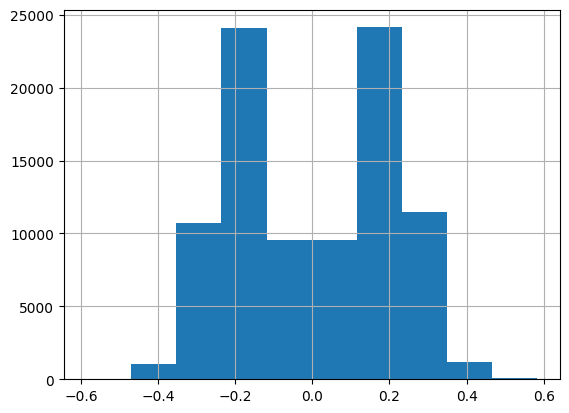

In [117]:
import numpy as np
pd.Series(np.ndarray.flatten(model.layers[4].weights[0].numpy())).hist()

In [121]:
model_factory = lambda : generate_quantized_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    layers=2,
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_regularizer=BinaryL1Regularizer(strength=0.0001, alpha=0.2),
    batch_norm_momentum=0.95,
    batch_norm_scale=True,
    batch_norm_center=True,
    single_batch_norm=True)[0]

optimizer = lambda : tf.keras.optimizers.experimental.AdamW(learning_rate=0.001, weight_decay=0.000, epsilon=1e-8)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)

num_runs = 1
epochs = 1000

run_experiment(
    experiment_name=f"binary_gcn_binaryl1_wd={weight_decay}", 
    num_runs=num_runs, 
    epochs=epochs, 
    optimizer=optimizer,
    dataset=dataset,
    model_factory=model_factory,
    loss_function=loss_function,
    callbacks=[early_stopping_callback],
    verbose=1,
    recreate_optimizer=True,
    )

  0%|          | 0/1 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).


Epoch 1/1000
1/1 [==============================] - 1s 843ms/step - loss: 3.4970 - accuracy: 0.1357 - val_loss: 3.4830 - val_accuracy: 0.1220
Epoch 2/1000
1/1 [==============================] - 0s 59ms/step - loss: 3.4918 - accuracy: 0.1286 - val_loss: 3.4741 - val_accuracy: 0.1220
Epoch 3/1000
1/1 [==============================] - 0s 58ms/step - loss: 3.4812 - accuracy: 0.1357 - val_loss: 3.4652 - val_accuracy: 0.1220
Epoch 4/1000
1/1 [==============================] - 0s 50ms/step - loss: 3.4715 - accuracy: 0.1571 - val_loss: 3.4563 - val_accuracy: 0.1220
Epoch 5/1000
1/1 [==============================] - 0s 74ms/step - loss: 3.4579 - accuracy: 0.1214 - val_loss: 3.4481 - val_accuracy: 0.1220
Epoch 6/1000
1/1 [==============================] - 0s 70ms/step - loss: 3.4494 - accuracy: 0.1429 - val_loss: 3.4400 - val_accuracy: 0.1220
Epoch 7/1000
1/1 [==============================] - 0s 72ms/step - loss: 3.4352 - accuracy: 0.1857 - val_loss: 3.4322 - val_accuracy: 0.1220
Epoch 8/1000

100%|██████████| 1/1 [00:52<00:00, 52.63s/it]

1 runs completed: 0.7786 mean train acc, 0.6900 mean val acc, 0.7040 mean test acc


In [124]:
model_factory = lambda : generate_quantized_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    layers=2,
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_regularizer=BinaryL2Regularizer(strength=0.0001, alpha=0.1),
    batch_norm_momentum=0.95,
    batch_norm_scale=True,
    batch_norm_center=True,
    single_batch_norm=True)[0]

optimizer = lambda : tf.keras.optimizers.experimental.AdamW(learning_rate=0.001, weight_decay=0.0001, epsilon=1e-8)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)

num_runs = 1
epochs = 1000

run_experiment(
    experiment_name=f"binary_gcn_binaryl2_wd={weight_decay}", 
    num_runs=num_runs, 
    epochs=epochs, 
    optimizer=optimizer,
    dataset=dataset,
    model_factory=model_factory,
    loss_function=loss_function,
    callbacks=[early_stopping_callback],
    verbose=1,
    recreate_optimizer=True
    )

  0%|          | 0/1 [00:00<?, ?it/s]Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).
Using a binary weight quantizer without setting `kernel_constraint` may result in starved weights (where the gradient is always zero).


Epoch 1/1000
1/1 [==============================] - 1s 900ms/step - loss: 1.9920 - accuracy: 0.1143 - val_loss: 1.9946 - val_accuracy: 0.0580
Epoch 2/1000
1/1 [==============================] - 0s 57ms/step - loss: 1.9855 - accuracy: 0.1929 - val_loss: 1.9950 - val_accuracy: 0.0580
Epoch 3/1000
1/1 [==============================] - 0s 53ms/step - loss: 1.9807 - accuracy: 0.1857 - val_loss: 1.9955 - val_accuracy: 0.0580
Epoch 4/1000
1/1 [==============================] - 0s 52ms/step - loss: 1.9806 - accuracy: 0.1929 - val_loss: 1.9961 - val_accuracy: 0.0580
Epoch 5/1000
1/1 [==============================] - 0s 46ms/step - loss: 1.9816 - accuracy: 0.1714 - val_loss: 1.9970 - val_accuracy: 0.0580
Epoch 6/1000
1/1 [==============================] - 0s 47ms/step - loss: 1.9841 - accuracy: 0.1643 - val_loss: 1.9958 - val_accuracy: 0.0580
Epoch 7/1000
1/1 [==============================] - 0s 56ms/step - loss: 1.9870 - accuracy: 0.0929 - val_loss: 1.9960 - val_accuracy: 0.0580
Epoch 8/1000

  0%|          | 0/1 [00:13<?, ?it/s]


KeyboardInterrupt: 

# Experiment 8: Increase number or width of layers (compare to standard GCN)

In [53]:
dataset = cora_dataset
input_shapes = (dataset.graphs[0].x.shape[1], dataset.graphs[0].a.shape[1])


for num_channels in [512, 1024]:
    model_factory = lambda : generate_quantized_gcn(
        channels=num_channels, 
        input_shapes=input_shapes, 
        dataset=dataset, 
        dropout_rate=0.4, 
        layers=2,
        input_quantizer=lq.quantizers.MagnitudeAwareSign,
        kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
        kernel_regularizer=None,
        batch_norm_momentum=0.95,
        batch_norm_scale=True,
        batch_norm_center=True)[0]


    num_runs = 20
    epochs = 1000
    optimizer = lambda : tf.keras.optimizers.experimental.AdamW(learning_rate=0.001, weight_decay=0.0001, epsilon=1e-8)
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")

    run_experiment(
        experiment_name=f"binary_gcn_width={num_channels}", 
        num_runs=num_runs, 
        epochs=epochs, 
        optimizer=optimizer,
        dataset=dataset,
        model_factory=model_factory,
        loss_function=loss_function,
        callbacks=[],
        verbose=0,
        recreate_optimizer=True,
        )

100%|██████████| 20/20 [27:57<00:00, 83.89s/it]


20 runs completed: 0.9921 mean train acc, 0.7942 mean val acc, 0.8029 mean test acc


100%|██████████| 20/20 [43:40<00:00, 131.03s/it]

20 runs completed: 0.9929 mean train acc, 0.7948 mean val acc, 0.8013 mean test acc


In [50]:
for num_layers in [5, 6]:
    model_factory = lambda : generate_quantized_gcn(
        layers=num_layers,
        channels=64, 
        input_shapes=input_shapes, 
        dataset=dataset, 
        dropout_rate=0.4, 
        input_quantizer=lq.quantizers.MagnitudeAwareSign,
        kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
        kernel_regularizer=None,
        batch_norm_momentum=0.95,
        batch_norm_scale=True,
        batch_norm_center=True)[0]


    num_runs = 20
    epochs = 1000
    optimizer = lambda : tf.keras.optimizers.experimental.AdamW(learning_rate=0.001, weight_decay=0.0001, epsilon=1e-8)
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
    
    run_experiment(
        experiment_name=f"binary_gcn_depth={num_layers}", 
        num_runs=num_runs, 
        epochs=epochs, 
        optimizer=optimizer,
        dataset=dataset,
        model_factory=model_factory,
        loss_function=loss_function,
        callbacks=[],
        verbose=0,
        recreate_optimizer=True,
        )

100%|██████████| 20/20 [22:29<00:00, 67.47s/it]


20 runs completed: 0.8050 mean train acc, 0.6904 mean val acc, 0.7122 mean test acc


100%|██████████| 20/20 [25:49<00:00, 77.50s/it]

20 runs completed: 0.5986 mean train acc, 0.5161 mean val acc, 0.5256 mean test acc


## Run same width/depth ablation for standard gcn

In [51]:
for num_layers in [3, 4, 5, 6]:
    model_factory = lambda : generate_standard_gcn(
        channels=64, 
        input_shapes=input_shapes, 
        dataset=cora_dataset, 
        dropout_rate=0.5, layers=num_layers)[0]
    epochs = 1000
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    # Note: need to explicitly specify reduction = "sum" to correctly scale loss, otherwise it will be divided by the batch size
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

    run_experiment(
        experiment_name=f"standard_gcn_depth={num_layers}", 
        num_runs=num_runs, 
        epochs=epochs, 
        optimizer=optimizer,
        dataset=cora_dataset,
        model_factory=model_factory,
        loss_function=loss_function,
        callbacks=[early_stopping_callback]
        )
    

100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


20 runs completed: 1.0000 mean train acc, 0.8029 mean val acc, 0.8051 mean test acc


100%|██████████| 20/20 [01:54<00:00,  5.72s/it]


20 runs completed: 1.0000 mean train acc, 0.7878 mean val acc, 0.7893 mean test acc


100%|██████████| 20/20 [02:23<00:00,  7.18s/it]


20 runs completed: 1.0000 mean train acc, 0.7742 mean val acc, 0.7696 mean test acc


100%|██████████| 20/20 [02:59<00:00,  8.96s/it]


20 runs completed: 0.9704 mean train acc, 0.7295 mean val acc, 0.7048 mean test acc


100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


20 runs completed: 1.0000 mean train acc, 0.8041 mean val acc, 0.8200 mean test acc


100%|██████████| 20/20 [02:01<00:00,  6.09s/it]


20 runs completed: 1.0000 mean train acc, 0.8048 mean val acc, 0.8217 mean test acc


100%|██████████| 20/20 [02:36<00:00,  7.84s/it]

20 runs completed: 1.0000 mean train acc, 0.8055 mean val acc, 0.8214 mean test acc


In [52]:

for width in [1024]:
    model_factory = lambda : generate_standard_gcn(
        channels=width, 
        input_shapes=input_shapes, 
        dataset=cora_dataset, 
        dropout_rate=0.5, layers=2)[0]
    epochs = 1000
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    # Note: need to explicitly specify reduction = "sum" to correctly scale loss, otherwise it will be divided by the batch size
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

    run_experiment(
        experiment_name=f"standard_gcn_width={width}", 
        num_runs=num_runs, 
        epochs=epochs, 
        optimizer=optimizer,
        dataset=cora_dataset,
        model_factory=model_factory,
        loss_function=loss_function,
        callbacks=[early_stopping_callback]
        )

100%|██████████| 20/20 [03:58<00:00, 11.92s/it]

20 runs completed: 1.0000 mean train acc, 0.8089 mean val acc, 0.8267 mean test acc


# Why is bigcn loss lower than standard but accuracy lower as well?

In [257]:
deep_std_model = generate_standard_gcn(
        channels=64,
        layers=6, 
        input_shapes=input_shapes, 
        dataset=cora_dataset, 
        dropout_rate=0.5)[0]
epochs = 1000
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# Note: need to explicitly specify reduction = "sum" to correctly scale loss, otherwise it will be divided by the batch size
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

loader_tr, loader_va, loader_te = generate_data_loaders(dataset)

history_dataframes = []
eval_data = []

# Clear out old model files
model_files = glob.glob("model_files/*")
for f in model_files:
    os.remove(f)


checkpoint_path = f"model_files/testing_run.tf"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

deep_std_model.compile(
    optimizer=optimizer, loss=loss_function, weighted_metrics=["accuracy"]
)

history = deep_std_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback],
    verbose=0,
)
# Restore best weights
deep_std_model.load_weights(checkpoint_path)
eval_results = deep_std_model.evaluate(
    loader_te.load(), steps=loader_te.steps_per_epoch, verbose=1
)

1/1 [==============================] - 0s 24ms/step - loss: 0.8940 - accuracy: 0.7770


In [258]:
deep_model = generate_quantized_gcn(
    layers=6,
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_regularizer=None,
    batch_norm_momentum=0.95,
    batch_norm_scale=True,
    batch_norm_center=True,
    softmax_temperature=1.0
    )[0]


num_runs = 20
epochs = 1000
optimizer = lambda : tf.keras.optimizers.experimental.AdamW(learning_rate=0.001, weight_decay=0.0001, epsilon=1e-8)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")

loader_tr, loader_va, loader_te = generate_data_loaders(dataset)

history_dataframes = []
eval_data = []

# Clear out old model files
model_files = glob.glob("model_files/*")
for f in model_files:
    os.remove(f)


checkpoint_path = f"model_files/testing_run.tf"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

opt = optimizer()

deep_model.compile(
    optimizer=opt, loss=loss_function, weighted_metrics=["accuracy"]
)

history = deep_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[checkpoint_callback],
    verbose=0,
)
# Restore best weights
deep_model.load_weights(checkpoint_path)
eval_results = deep_model.evaluate(
    loader_te.load(), steps=loader_te.steps_per_epoch, verbose=1
)

1/1 [==============================] - 0s 30ms/step - loss: 1.1508 - accuracy: 0.6270


0.8939538     0.7769996
1.1508324     0.62699986


array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>,
       <AxesSubplot: title={'center': '2'}>,
       <AxesSubplot: title={'center': '3'}>,
       <AxesSubplot: title={'center': '4'}>,
       <AxesSubplot: title={'center': '5'}>,
       <AxesSubplot: title={'center': '6'}>,
       <AxesSubplot: title={'center': '7'}>,
       <AxesSubplot: title={'center': '8'}>,
       <AxesSubplot: title={'center': '9'}>], dtype=object)

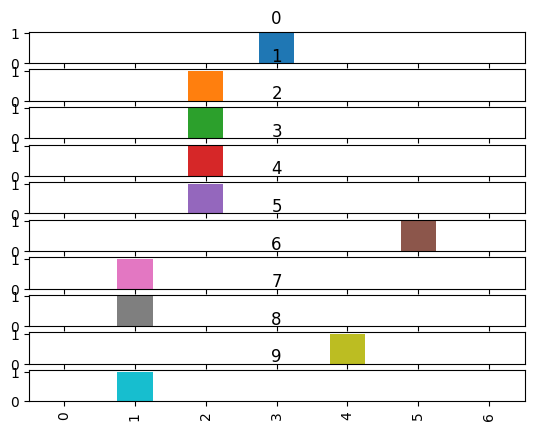

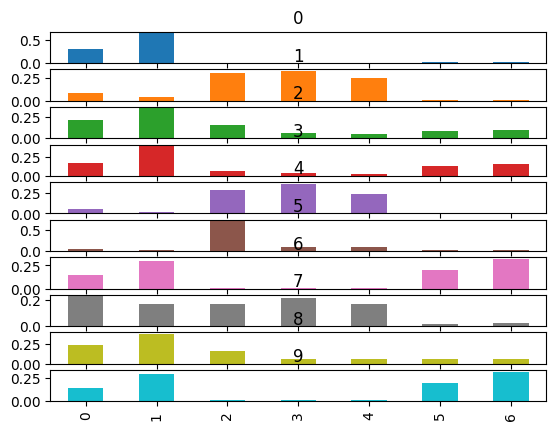

In [259]:
for inputs, labels, weights in loader_te:
    break

std_loss = tf.math.reduce_sum((tf.keras.losses.categorical_crossentropy(labels, deep_std_model(inputs)) * weights)).numpy()
std_acc = tf.math.reduce_sum(tf.keras.metrics.categorical_accuracy(labels, deep_std_model(inputs)) * weights).numpy()
print(std_loss, "   ", std_acc)

bi_loss = tf.math.reduce_sum((tf.keras.losses.categorical_crossentropy(labels, deep_model(inputs)) * weights)).numpy()
bi_acc = tf.math.reduce_sum(tf.keras.metrics.categorical_accuracy(labels, deep_model(inputs)) * weights).numpy()
print(bi_loss, "   ", bi_acc)

import numpy as np

test_accuracies = tf.keras.metrics.categorical_accuracy(labels, deep_model(inputs))[1708:].numpy()
wrong_answer = np.nonzero(test_accuracies - 1)[0] + 1708

pd.DataFrame(labels[wrong_answer])[:10].T.plot(kind="bar", subplots=True, legend=None)
pd.DataFrame(deep_model(inputs).numpy()[wrong_answer])[:10].T.plot(kind="bar", subplots=True, legend=None)

In [260]:
def concentration(predictions):
    return tf.norm(predictions, axis=-1)

deep_bi_predictions = deep_model(inputs)
deep_bi_concentrations = concentration(deep_bi_predictions)
deep_std_predictions = deep_std_model(inputs)
deep_std_concentrations = concentration(deep_std_predictions)

Text(0.5, 1.0, 'Histogram of Euclidean Norms of Test Predictions')

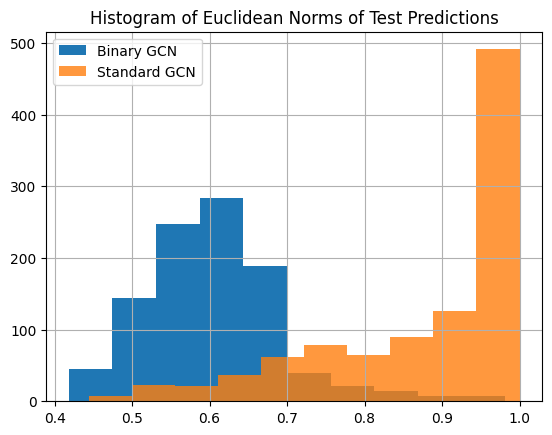

In [261]:
pd.Series(deep_bi_concentrations.numpy()[-1000:]).hist(label="Binary GCN")
ax=pd.Series(deep_std_concentrations.numpy()[-1000:]).hist(label="Standard GCN", alpha=0.8)
ax.legend()
ax.set_title("Histogram of Euclidean Norms of Test Predictions")

# Is there greater dispersion with only 2 layers?

In [262]:
std_model = generate_standard_gcn(
        channels=64,
        layers=2, 
        input_shapes=input_shapes, 
        dataset=cora_dataset, 
        dropout_rate=0.5)[0]
epochs = 1000
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# Note: need to explicitly specify reduction = "sum" to correctly scale loss, otherwise it will be divided by the batch size
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

loader_tr, loader_va, loader_te = generate_data_loaders(dataset)

history_dataframes = []
eval_data = []

# Clear out old model files
model_files = glob.glob("model_files/*")
for f in model_files:
    os.remove(f)


checkpoint_path = f"model_files/testing_run.tf"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

std_model.compile(
    optimizer=optimizer, loss=loss_function, weighted_metrics=["accuracy"]
)

history = std_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback],
    verbose=0,
)
# Restore best weights
std_model.load_weights(checkpoint_path)
eval_results = std_model.evaluate(
    loader_te.load(), steps=loader_te.steps_per_epoch, verbose=1
)

1/1 [==============================] - 0s 13ms/step - loss: 0.6553 - accuracy: 0.8080


In [263]:
model = generate_quantized_gcn(
    layers=2,
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_regularizer=None,
    batch_norm_momentum=0.95,
    batch_norm_scale=True,
    batch_norm_center=True,
    softmax_temperature=1.0
    )[0]


num_runs = 20
epochs = 1000
optimizer = lambda : tf.keras.optimizers.experimental.AdamW(learning_rate=0.001, weight_decay=0.0001, epsilon=1e-8)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")

loader_tr, loader_va, loader_te = generate_data_loaders(dataset)

history_dataframes = []
eval_data = []

# Clear out old model files
model_files = glob.glob("model_files/*")
for f in model_files:
    os.remove(f)


checkpoint_path = f"model_files/testing_run.tf"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

opt = optimizer()

model.compile(
    optimizer=opt, loss=loss_function, weighted_metrics=["accuracy"]
)

history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[checkpoint_callback],
    verbose=0,
)
# Restore best weights
model.load_weights(checkpoint_path)
eval_results = model.evaluate(
    loader_te.load(), steps=loader_te.steps_per_epoch, verbose=1
)

1/1 [==============================] - 0s 19ms/step - loss: 0.6066 - accuracy: 0.8050


In [268]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Euclidean Norm')

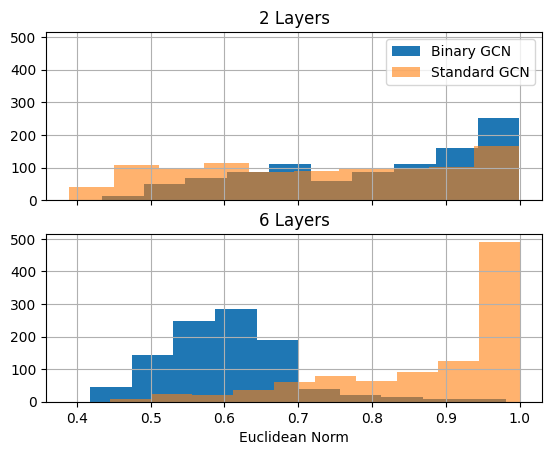

In [278]:
for inputs, labels, weights in loader_te:
    break

def concentration(predictions):
    return tf.norm(predictions, axis=-1)

bi_predictions = model(inputs)
bi_concentrations = concentration(bi_predictions)
std_predictions = std_model(inputs)
std_concentrations = concentration(std_predictions)


fig, ax = plt.subplots(2, sharex=True, sharey=True)
pd.Series(bi_concentrations.numpy()[-1000:]).hist(label="Binary GCN", ax=ax[0])
pd.Series(std_concentrations.numpy()[-1000:]).hist(label="Standard GCN", alpha=0.6, ax=ax[0])

pd.Series(deep_bi_concentrations.numpy()[-1000:]).hist(label="Deep Binary GCN", ax=ax[1])
pd.Series(deep_std_concentrations.numpy()[-1000:]).hist(label="Deep Standard GCN", alpha=0.6, ax=ax[1])
ax[0].legend()
#ax[0].set_title("Histogram of Euclidean Norms of Test Predictions\n\n2 Layers")
ax[0].set_title("2 Layers")
ax[1].set_title("6 Layers")
ax[1].set_xlabel("Euclidean Norm")

# Training deep Bi-GCN with low softmax temp fixes dispersion

In [276]:
softmax_temp = 0.1
model_factory = lambda : generate_quantized_gcn(
    layers=6,
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_regularizer=None,
    batch_norm_momentum=0.95,
    batch_norm_scale=True,
    batch_norm_center=True,
    softmax_temperature=softmax_temp)[0]


num_runs = 20
epochs = 1000
optimizer = lambda : tf.keras.optimizers.experimental.AdamW(learning_rate=0.001, weight_decay=0.0001, epsilon=1e-8)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")

run_experiment(
    experiment_name=f"binary_gcn_deep_temperature={softmax_temp}", 
    num_runs=num_runs, 
    epochs=epochs, 
    optimizer=optimizer,
    dataset=dataset,
    model_factory=model_factory,
    loss_function=loss_function,
    callbacks=[],
    verbose=0,
    recreate_optimizer=True,
    )

100%|██████████| 20/20 [24:53<00:00, 74.66s/it]

20 runs completed: 0.7371 mean train acc, 0.6836 mean val acc, 0.6954 mean test acc


# Experiment 9: Use Bop Optimizer

In [ ]:
# Bop training notes:
# Warming up and cooling down gamma seems to have a good effect
# Also resetting the optimizer every x train steps helps with the accumlated gradients
# Small adam learning rate seems to be helpful
# Some ok param settings:
    # gamma_initial = 0
    # gamma_target = 1e-08
    # gamma_decay = 0.99
    # warmup = 5
    # threshold = 1e-8
    # threshold_increase = 1.0



In [ ]:
dataset = cora_dataset
input_shapes = (dataset.graphs[0].x.shape[1], dataset.graphs[0].a.shape[1])
loader_tr, loader_va, loader_te = generate_data_loaders(dataset)
model = generate_quantized_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    layers=2,
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    batch_norm_momentum=0.95,
    batch_norm_scale=True,
    batch_norm_center=True,
    single_batch_norm=True,
    kernel_constraint="weight_clip",
    kernel_initializer="he_uniform")[0]
initial_optimizer=tf.keras.optimizers.Adam(0.01)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)


gamma_initial = 0
gamma_target = 1e-08
gamma_decay = 0.99
warmup = 5

threshold = 4e-8
threshold_decay = 1.0
epochs = 20

training_history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[], "gamma":[], "threshold":[]}
for i in range(100):

    if i < warmup:
        gamma = gamma_target * (i+1) / warmup

    print(f"train run {i}, threshold={threshold:.3}, gamma={gamma:.3}" )

    case_optimizer = lq.optimizers.CaseOptimizer(
    (
        lq.optimizers.Bop.is_binary_variable,  # predicate
        lq.optimizers.Bop(threshold=threshold, gamma=gamma),  # optimizer
    ),
    default_optimizer=tf.keras.optimizers.Adam(0.0001))

    model.compile(
        optimizer=case_optimizer,
        loss=loss_function,
        weighted_metrics=["accuracy"])

    history = model.fit(
        loader_tr.load(),
        steps_per_epoch=loader_tr.steps_per_epoch,
        validation_data=loader_va.load(),
        validation_steps=loader_va.steps_per_epoch,
        epochs=epochs,
        callbacks=[],
        verbose=1
    )
    history.history["gamma"] = [gamma] * epochs
    history.history["threshold"] = [threshold] * epochs
    #model.evaluate(loader_va.load(), steps=loader_va.steps_per_epoch, verbose=2)
    gamma *= gamma_decay
    threshold *= threshold_decay
    for k, v in history.history.items():
        training_history[k] += v



In [ ]:
import matplotlib.pyplot as plt
import pandas as od
history_df = pd.DataFrame(training_history)
history_df[["accuracy", "val_accuracy"]].plot()
ax = history_df[["loss", "val_loss"]].plot()
ax.set_yscale("log")
history_df[["threshold", "gamma"]].plot(ax=ax.twinx(), )

In [ ]:
checkpoint = model.get_weights()

In [ ]:
import numpy as np
model.set_weights(checkpoint)
case_optimizer = lq.optimizers.CaseOptimizer(
(
    lq.optimizers.Bop.is_binary_variable,  # predicate
    lq.optimizers.Bop(threshold=1e-8, gamma=0.5e-8),  # optimizer
),
default_optimizer=None)

model.compile(
        optimizer=case_optimizer,
        loss=loss_function,
        weighted_metrics=["accuracy"])

history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=200,
    callbacks=[],
    verbose=0
)
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()

In [ ]:
import matplotlib.pyplot as plt
import pandas as od
history_df = pd.DataFrame(training_history)
history_df[["accuracy", "val_accuracy"]].plot()
ax = history_df[["loss", "val_loss"]].plot()
ax.set_yscale("log")
history_df[["threshold", "gamma"]].plot(ax=ax.twinx(), )

In [ ]:
import matplotlib.pyplot as plt
import pandas as od
history_df = pd.DataFrame(training_history)
history_df[["accuracy", "val_accuracy"]].plot()
ax = history_df[["loss", "val_loss"]].plot()
ax.set_yscale("log")
history_df[["threshold", "gamma"]].plot()

In [ ]:
import matplotlib.pyplot as plt
import pandas as od
history_df = pd.DataFrame(training_history)
history_df[["accuracy", "val_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(training_history["accuracy"])
plt.plot(training_history["val_accuracy"])

In [ ]:
# Hyperp

# Experiment 10: Use two-part learning, start with full precision, then do second phase of binarized learning

In [ ]:
dataset = cora_dataset
input_shapes = (cora_dataset.graphs[0].x.shape[1], cora_dataset.graphs[0].a.shape[1])
full_precision_model = generate_standard_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    layers=2,
    activation=lq.quantizers.MagnitudeAwareSign,
    batch_norm_momentum=0.9,
    batch_norm_scale=True,
    batch_norm_center=True,
    single_batch_norm=True,
    use_batch_norm=True,
    preactivation=True)[0]

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# Note: need to explicitly specify reduction = "sum" to correctly scale loss, otherwise it will be divided by the batch size
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

epochs = 1000
loader_tr, loader_va, loader_te = generate_data_loaders(dataset)

full_precision_model.compile(
    optimizer=optimizer,
    loss=loss_function,
    weighted_metrics=["accuracy"]
)

history = full_precision_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[early_stopping_callback],
    verbose=0
)
print("Num epochs: ", len(history.history["loss"]))
full_precision_model.evaluate(loader_va.load(), steps=loader_va.steps_per_epoch, verbose=2)

In [ ]:
def initialize_from_full_precision(full_precision_model):
    binary_model = generate_quantized_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    layers=2,
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    batch_norm_momentum=0.9,
    batch_norm_scale=True,
    batch_norm_center=True,
    single_batch_norm=True)[0]

    # Need to do this to build the model
    binary_model.predict(loader_te.load(), steps=loader_te.steps_per_epoch)

    for bin_l, fp_l in zip(binary_model.layers, full_precision_model.layers):
        bin_l.set_weights(fp_l.get_weights())

    return binary_model

In [ ]:
bin_model = initialize_from_full_precision(full_precision_model)
bin_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, epsilon=1e-8),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum"),
    weighted_metrics=["accuracy"]
    )
bin_model.evaluate(loader_va.load(), steps=loader_va.steps_per_epoch, verbose=2)

In [ ]:
model_factory = lambda : initialize_from_full_precision(full_precision_model)

no_op_quantizer = lq.quantizers.NoOpQuantizer(precision=1)
layer = lq.layers.QuantDense(16, kernel_quantizer=no_op_quantizer)
case_optimizer = lq.optimizers.CaseOptimizer(
    (
        lq.optimizers.Bop.is_binary_variable,  # predicate
        lq.optimizers.Bop(threshold=1e-7, gamma=1e-4),  # optimizer
    ),
    default_optimizer=tf.keras.optimizers.Adam(0.001),
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)

num_runs = 1
epochs = 1000

run_experiment(
    experiment_name=f"binary_gcn_fp_init", 
    num_runs=num_runs, 
    epochs=epochs, 
    optimizer=optimizer,
    dataset=dataset,
    model_factory=model_factory,
    loss_function=loss_function,
    callbacks=[early_stopping_callback, tf.keras.callbacks.TensorBoard("tensorboard")],
    verbose=2
    )

# Experiment 11: Learning rate schedules

In [ ]:
model_factory = lambda : generate_quantized_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    layers=2,
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    batch_norm_momentum=0.9,
    batch_norm_scale=True,
    batch_norm_center=True,
    single_batch_norm=True)[0]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=100)

num_runs = 1
epochs = 1000

model.compile(
    optimizer=optimizer,
    loss=loss_function,
    weighted_metrics=["accuracy"])

history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[],
    verbose=1
)

# Experiment 12: Ternary version

In [ ]:
model_factory = lambda : generate_quantized_gcn(
    channels=64, 
    input_shapes=input_shapes, 
    dataset=dataset, 
    dropout_rate=0.4, 
    layers=2,
    input_quantizer=lq.quantizers.MagnitudeAwareSign,
    kernel_quantizer=lq.quantizers.MagnitudeAwareSign,
    batch_norm_momentum=0.9,
    batch_norm_scale=True,
    batch_norm_center=True,
    single_batch_norm=True)[0]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=500, restore_best_weights=True)

num_runs = 1
epochs = 1000

run_experiment(
    experiment_name=f"ternary_gcn", 
    num_runs=num_runs, 
    epochs=epochs, 
    optimizer=optimizer,
    dataset=dataset,
    model_factory=model_factory,
    loss_function=loss_function,
    callbacks=[early_stopping_callback],
    verbose=2
    )

# Additional Experiment: Sign quantizers
SteSign seems to do much worse than MagnitudeAwareSign. Is this because of the scale factor, or just bad hyperparameter tuning?
Look into whether the input quantizer can be changed to ste_sign